In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pylab as pl
from pathlib import Path
import seaborn as sns
from dotmap import DotMap
from pathlib import Path
from collections.abc import Mapping, Callable

from IPython.display import display

In [2]:
DATA = Path("./data")
df_flags = pd.read_csv(
    DATA / "definitions_and_standards/flags.csv",
    keep_default_na=False,
    index_col="Flag"
)
# Helper function

def join_flags(df, filepath, df_flags):
    df["Flag"] = pd.read_csv(filepath, encoding="latin1", usecols=["Flag"], keep_default_na=False)
    return df.merge(df_flags, on="Flag").drop(columns="Flag").rename(columns={"Flags": "Flag"})

def split_on(df, column, rename={}, only_named=False):
    """
    Splits a dataframe in multiple dataframe based on the value of a columne
    
    Args:
        df: dataframe to spli
        column: name of the column to split on
        rename (optional): mapping or callable that rename values to name in the final dictionary
        only_named (False): keep only dataframe with a value in column that is renamed
    
    Returns:
        A dictionnary mapping unique values in df[column] to the dataframe with that value.
        Value (i.e. dict keys) can be renamed by the rename argument. A callable can return None to not rename it.
    """
    result = DotMap(_dynamic=False)
    for value in df[column].unique():
        if callable(rename):
            name = rename(value)
        elif isinstance(rename, Mapping):
            name = rename.get(value)
        else:
            name = None
        if name is None and only_named:
            continue
        result[name or value] = df[ df[column] == value].drop(columns=column)
    return result

def select_on(df, columns, dict_elements):
    for column in columns:
        elements = dict_elements[column]
        df = df[df[column].isin(elements)]
    return df

## Loading tables

In [72]:
Enteric_Fermentation_PATH = DATA / "global-food-agriculture-statistics/current_FAO/raw_files/Emissions_Agriculture_Enteric_Fermentation_E_All_Data_(Norm).csv"
Manure_soils_PATH = DATA / "global-food-agriculture-statistics/current_FAO/raw_files/Emissions_Agriculture_Manure_applied_to_soils_E_All_Data_(Norm).csv"
Manure_management_PATH = DATA / "global-food-agriculture-statistics/current_FAO/raw_files/Emissions_Agriculture_Manure_Management_E_All_Data_(Norm).csv"
Manure_pasture_PATH = DATA / "global-food-agriculture-statistics/current_FAO/raw_files/Emissions_Agriculture_Manure_left_on_pasture_E_All_Data_(Norm).csv"
df_enteric_fermentation = pd.read_csv(Enteric_Fermentation_PATH, encoding="ISO-8859-1")
df_manure_soils = pd.read_csv(Manure_soils_PATH,encoding="ISO-8859-1")
df_manure_management = pd.read_csv(Manure_management_PATH,encoding="ISO-8859-1")
df_manure_pasture = pd.read_csv(Manure_pasture_PATH,encoding="ISO-8859-1")


Joining each table with the *flag* table to have the flag meaning

In [73]:
df_enteric_fermentation = join_flags(df_enteric_fermentation,\
                                    Enteric_Fermentation_PATH,\
                                    df_flags)
df_manure_soils = join_flags(df_manure_soils,\
                                    Manure_soils_PATH,\
                                    df_flags)
df_manure_management = join_flags(df_manure_management,\
                                    Manure_management_PATH,\
                                    df_flags)
df_manure_pasture = join_flags(df_manure_pasture,\
                                    Manure_pasture_PATH,\
                                    df_flags)


# Tables description

Each of the 4 tables have the same columns, which are described below:

In [74]:
df_enteric_fermentation.columns

Index(['Country Code', 'Country', 'Item Code', 'Item', 'Element Code',
       'Element', 'Year Code', 'Year', 'Unit', 'Value', 'Flag'],
      dtype='object')


- **Country code**: unique identifier of countries
- **Country**
- **Item**: Animal
- **Item Code**: unique identifier of Animal
- **Element**: type of GHG(Greenhouse gaz) emission / Stock
- **Element Code**: unique identifier of the type of emission
- **Year**
- **Year Code**
- **Unit**: Unit of Element
- **Value**: Value of Element
- **Flag**: Origin of the data
 


For each of these 4 tables we will start by cleaning and preprocessing the data, then do a quick analysis of the livestock species(asses, buffaloes, camels...) to see the animals that produce the most emissions in the world first by the total number of livestock species then only by head. 

# Enteric Fermentation
The table ‘Enteric Fermentation’ contains the following data:
country-level GHG(Greenhouse gaz) emissions in both Gg CH4 and Gg CO2eq, by animal categories and their aggregates, as well as their total; implied emission factors; and activity data.

In [75]:
df_enteric_fermentation.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,1107,Asses,5111,Stocks,1961,1961,Head,1300000.0,Official data
1,2,Afghanistan,1107,Asses,5111,Stocks,1962,1962,Head,851850.0,Official data
2,2,Afghanistan,1107,Asses,5111,Stocks,1963,1963,Head,1001112.0,Official data
3,2,Afghanistan,1107,Asses,5111,Stocks,1965,1965,Head,1300000.0,Official data
4,2,Afghanistan,1107,Asses,5111,Stocks,1966,1966,Head,1200000.0,Official data


In [127]:
df_enteric_fermentation.isna().any()

Country Code    False
Country         False
Item Code       False
Item            False
Element Code    False
Element         False
Year Code       False
Year            False
Unit            False
Value           False
Flag            False
dtype: bool

No null values in this table

In [76]:
print("Unique years :",df_enteric_fermentation["Year"].unique())
print("Unique flags :",df_enteric_fermentation["Flag"].unique())

Unique years : [1961 1962 1963 1965 1966 1967 1968 1969 1970 1971 1972 1977 1987 1999
 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 1978 1979 1980 1981 1982 1986 1973 1974 1975 1976 1995 1998 1991
 1997 1988 1989 1990 1964 1992 1993 1994 1996 1985 1983 1984 2030 2050]
Unique flags : ['Official data' 'FAO estimate' 'Unofficial figure' 'Calculated data'
 'Aggregate, may include official, semi-official, estimated or calculated data'
 'FAO data based on imputation methodology']


In [77]:
#Removing predictions of future years
df_enteric_fermentation = df_enteric_fermentation[df_enteric_fermentation["Year"]<2030]

#Description of Element column
df_enteric_fermentation["Element"].unique()

array(['Stocks', 'Implied emission factor for CH4 (Enteric)',
       'Emissions (CH4) (Enteric)', 'Emissions (CO2eq) (Enteric)'],
      dtype=object)

In the *Element* column we will only be interested in the value of *Stocks* which corresponds to the total number of livestock species(asses, buffaloes, camels...) and the value of *Emissions (CO2eq) (Enteric)* which corresponds to the total aggregate of the GHG emission in CO2eq

- Element Column :

In [78]:
#Filter the Element Column
split_enteric_fermentation = split_on(df_enteric_fermentation, "Element")
stocks_enteric_fermentation_by_animals = split_enteric_fermentation["Stocks"]
emission_enteric_fermentation_by_animals = split_enteric_fermentation["Emissions (CO2eq) (Enteric)"]

print("Stock unit :", stocks_enteric_fermentation_by_animals["Unit"].unique())
print("Emission unit :", emission_enteric_fermentation_by_animals["Unit"].unique())

#Removing unit and renaming Value column as we only have one Unit
stocks_enteric_fermentation_by_animals.drop("Unit", axis=1, inplace=True)
emission_enteric_fermentation_by_animals.drop("Unit", axis=1, inplace=True)
stocks_enteric_fermentation_by_animals.rename(columns={"Value": "Value (Head)"}, inplace=True)
emission_enteric_fermentation_by_animals.rename(columns={"Value": "Value (Gigagrams)"}, inplace=True)


Stock unit : ['Head']
Emission unit : ['Gigagrams']


- Item Column :

The Item column contains all the livestock species as well as some groups of animals, we will filter those and only keep the different animals


In [80]:
print(df_enteric_fermentation["Item"].unique())

Animals = ['Asses', 'Buffaloes', 'Camels','Cattle', 'Cattle, dairy', 'Cattle, non-dairy',
           'Goats', 'Horses','Llamas', 'Mules','Sheep','Swine']

dict_elements = {"Country" : ["World"],"Item" : Animals}
columns = ["Country","Item"]
df_filter_stock = select_on(stocks_enteric_fermentation_by_animals,columns,dict_elements)
df_filter_emission = select_on(emission_enteric_fermentation_by_animals,columns,dict_elements)

['Asses' 'Camels' 'Goats' 'Horses' 'Mules' 'Sheep' 'Buffaloes'
 'Cattle, dairy' 'Cattle, non-dairy' 'Swine, breeding' 'Swine, market'
 'Llamas' 'All Animals' 'Camels and Llamas' 'Cattle' 'Mules and Asses'
 'Sheep and Goats' 'Swine']


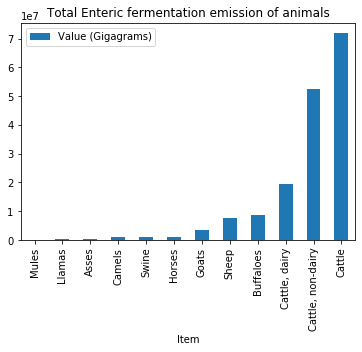

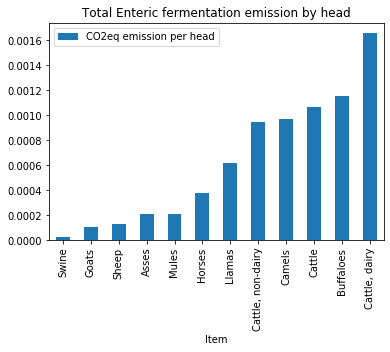

In [81]:
#Grouping stocks count
df_enteric_fermentation_grouped_stock = df_filter_stock.groupby(["Item"])\
                                ['Value (Head)'].sum().reset_index()
#Grouping total emissions count
df_enteric_fermentation_grouped_emission = df_filter_emission.groupby(["Item"])\
                                ['Value (Gigagrams)'].sum().reset_index()

df_enteric_fermentation_grouped_emission.sort_values("Value (Gigagrams)").plot\
.bar("Item",
      title="Total Enteric fermentation\
 emission of animals")

#Merging to get emission by head
merged = pd.merge(df_enteric_fermentation_grouped_emission,\
                  df_enteric_fermentation_grouped_stock,\
                  on = "Item")
merged["CO2eq emission per head"] = merged["Value (Gigagrams)"] / merged["Value (Head)"]
merged.sort_values("CO2eq emission per head").plot\
.bar(x="Item",
     y="CO2eq emission per head",
     title="Total Enteric fermentation emission by head")
        

# Manure Soils
The table ‘Manure applied to Soils’ contains the following data:


GHG emissions from manure applied to soils consisting of direct and indirect nitrous oxide (N2O) emissions from manure nitrogen (N) added to agricultural soils by farmers.

In [148]:
df_manure_soils.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,1107,Asses,5111,Stocks,1961,1961,Head,1300000.0,Official data
1,2,Afghanistan,1107,Asses,5111,Stocks,1962,1962,Head,851850.0,Official data
2,2,Afghanistan,1107,Asses,5111,Stocks,1963,1963,Head,1001112.0,Official data
3,2,Afghanistan,1107,Asses,5111,Stocks,1965,1965,Head,1300000.0,Official data
4,2,Afghanistan,1107,Asses,5111,Stocks,1966,1966,Head,1200000.0,Official data


- Checking for null values

In [48]:
print(df_manure_soils.isna().any())
print("Array of years will null values :", df_manure_soils[df_manure_soils["Value"].isna()]["Year"].unique())

#Removing null values(only in predictions)
df_manure_soils = df_manure_soils[df_manure_soils["Year"]<2030]

Country Code    False
Country         False
Item Code       False
Item            False
Element Code    False
Element         False
Year Code       False
Year            False
Unit            False
Value            True
Flag            False
dtype: bool
Array of years will null values : [2030 2050]


- Element column :

In [152]:
df_manure_soils["Element"].unique()

array(['Stocks', 'Manure (N content) (Manure applied)',
       'Implied emission factor for N2O (Manure applied)',
       'Direct emissions (N2O) (Manure applied)',
       'Direct emissions (CO2eq) (Manure applied)',
       'Indirect emissions (N2O) (Manure applied)',
       'Indirect emissions (CO2eq) (Manure applied)',
       'Emissions (N2O) (Manure applied)',
       'Emissions (CO2eq) (Manure applied)'], dtype=object)

Similarly to the previous table, in the *Element* column we will only be interested in the value of *Stocks* and the value of *Emissions (CO2eq) (Manure applied)* which corresponds to the total aggregate of the GHG emission in CO2eq

In [49]:
#Filter the Element Column
split_manure_soils = split_on(df_manure_soils, "Element")
stocks_manure_soils_by_animals = split_manure_soils["Stocks"]
emission_manure_soils_by_animals = split_manure_soils["Emissions (CO2eq) (Manure applied)"]

print("Stock unit :", stocks_manure_soils_by_animals["Unit"].unique())
print("Emission unit :", emission_manure_soils_by_animals["Unit"].unique())

#Removing unit and renaming Value column as we only have one Unit
stocks_manure_soils_by_animals.drop("Unit", axis=1, inplace=True)
emission_manure_soils_by_animals.drop("Unit", axis=1, inplace=True)
stocks_manure_soils_by_animals.rename(columns={"Value": "Value (Head)"}, inplace=True)
emission_manure_soils_by_animals.rename(columns={"Value": "Value (Gigagrams)"}, inplace=True)

Stock unit : ['Head']
Emission unit : ['Gigagrams']


- Item column : Removing groups of animals

In [50]:
print(df_manure_soils["Item"].unique())

Animals = ['Asses', 'Camels', 'Cattle, dairy', 'Cattle, non-dairy', 'Goats', 'Horses',
           'Mules', 'Sheep','Cattle','Chickens', 'Poultry Birds','Buffaloes', 'Ducks',
           'Turkeys', 'Swine', 'Llamas']

#Filtering animals
dict_elements = {"Country" : ["World"],"Item" : Animals}
columns = ["Country","Item"]
df_filter_stock = select_on(stocks_manure_soils_by_animals,columns,dict_elements)
df_filter_emission = select_on(emission_manure_soils_by_animals,columns,dict_elements)

['Asses' 'Camels' 'Goats' 'Horses' 'Mules' 'Sheep' 'Buffaloes' 'Ducks'
 'Turkeys' 'Cattle, dairy' 'Cattle, non-dairy' 'Chickens, broilers'
 'Chickens, layers' 'Swine, breeding' 'Swine, market' 'Llamas'
 'All Animals' 'Camels and Llamas' 'Cattle' 'Chickens' 'Mules and Asses'
 'Poultry Birds' 'Sheep and Goats' 'Swine']


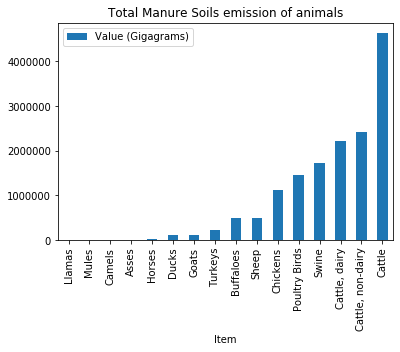

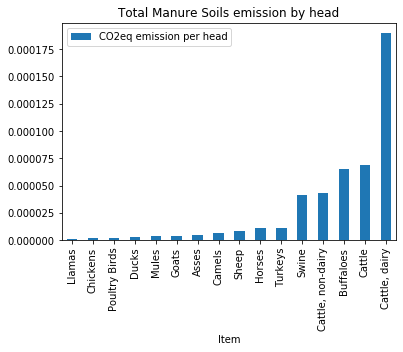

In [51]:
#Grouping stocks count
df_manure_soils_grouped_stock = df_filter_stock.groupby(["Item"])\
                                ['Value (Head)'].sum().reset_index()
#Grouping total emissions count
df_manure_soils_grouped_emission = df_filter_emission.groupby(["Item"])\
                                ['Value (Gigagrams)'].sum().reset_index()

df_manure_soils_grouped_emission.sort_values("Value (Gigagrams)").plot\
.bar(x="Item",
     y="Value (Gigagrams)",
     title="Total Manure Soils\
 emission of animals")

#Merging to get emission by head
merged = pd.merge(df_manure_soils_grouped_emission,\
                  df_manure_soils_grouped_stock,\
                  on = "Item")
merged["CO2eq emission per head"] = merged["Value (Gigagrams)"] / merged["Value (Head)"]
merged.sort_values("CO2eq emission per head").plot\
.bar(x="Item", y="CO2eq emission per head", title="Total Manure Soils emission by head")
        

# Manure Pasture
The table ‘Manure_Pasture’ contains the following data:

GHG emissions from manure left on pastures consisting of direct and indirect nitrous oxide (N2O) emissions from manure nitrogen (N) left on pastures by grazing livestock.

In [167]:
df_manure_pasture.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,1107,Asses,723602,Indirect emissions (N2O that leaches) (Manure ...,1961,1961,Gigagrams,0.0953,Calculated data
1,2,Afghanistan,1107,Asses,723602,Indirect emissions (N2O that leaches) (Manure ...,1962,1962,Gigagrams,0.0625,Calculated data
2,2,Afghanistan,1107,Asses,723602,Indirect emissions (N2O that leaches) (Manure ...,1963,1963,Gigagrams,0.0734,Calculated data
3,2,Afghanistan,1107,Asses,723602,Indirect emissions (N2O that leaches) (Manure ...,1964,1964,Gigagrams,0.0843,Calculated data
4,2,Afghanistan,1107,Asses,723602,Indirect emissions (N2O that leaches) (Manure ...,1965,1965,Gigagrams,0.0953,Calculated data


- Checking for null values

In [53]:
print(df_manure_pasture.isna().any())
print("Array of years will null values :",df_manure_pasture[df_manure_pasture["Value"].isna()]["Year"].unique())

#Removing null values(only in predictions)
df_manure_pasture = df_manure_pasture[df_manure_pasture["Year"]<2030]

Country Code    False
Country         False
Item Code       False
Item            False
Element Code    False
Element         False
Year Code       False
Year            False
Unit            False
Value            True
Flag            False
dtype: bool
Array of years will null values : [2030 2050]


- Element column :

In [171]:
df_manure_pasture["Element"].unique()

array(['Indirect emissions (N2O that leaches) (Manure on pasture)',
       'Indirect emissions (N2O that volatilises) (Manure on pasture)',
       'Manure (N content that leaches) (Manure on pasture)',
       'Manure (N content that volatilises) (Manure on pasture)',
       'Manure (N content) (Manure on pasture)',
       'Implied emission factor for N2O (Manure on pasture)',
       'Direct emissions (N2O) (Manure on pasture)',
       'Direct emissions (CO2eq) (Manure on pasture)',
       'Indirect emissions (N2O) (Manure on pasture)',
       'Indirect emissions (CO2eq) (Manure on pasture)',
       'Emissions (N2O) (Manure on pasture)',
       'Emissions (CO2eq) (Manure on pasture)', 'Stocks'], dtype=object)

Similarly, in the *Element* column we will only be interested in the value of *Stocks* and the value of *Emissions (CO2eq) (Manure on pasture)* which corresponds to the total aggregate of the GHG emission in CO2eq

In [54]:
#Filter the Element column
split_manure_pasture = split_on(df_manure_pasture, "Element")
stocks_manure_pasture_by_animals = split_manure_pasture["Stocks"]
emission_manure_pasture_by_animals = split_manure_pasture["Emissions (CO2eq) (Manure on pasture)"]

print("Stock unit :", stocks_manure_pasture_by_animals["Unit"].unique())
print("Emission unit :", emission_manure_pasture_by_animals["Unit"].unique())

#Removing unit and renaming Value column as we only have one Unit
stocks_manure_pasture_by_animals.drop("Unit", axis=1, inplace=True)
emission_manure_pasture_by_animals.drop("Unit", axis=1, inplace=True)
stocks_manure_pasture_by_animals.rename(columns={"Value": "Value (Head)"}, inplace=True)
emission_manure_pasture_by_animals.rename(columns={"Value": "Value (Gigagrams)"}, inplace=True)

Stock unit : ['Head']
Emission unit : ['Gigagrams']


- Item column : Removing groups of animals

In [57]:
print(df_manure_pasture["Item"].unique())

Animals = ['Asses', 'Camels', 'Cattle, dairy', 'Cattle, non-dairy','Goats', 'Horses',
           'Mules', 'Sheep', 'Buffaloes', 'Ducks','Turkeys', 'Llamas','Cattle', 'Chickens',
           'Poultry Birds', 'Swine']

#Filtering animals
dict_elements = {"Country" : ["World"],"Item" : Animals}
columns = ["Country","Item"]
df_filter_stock = select_on(stocks_manure_pasture_by_animals,columns,dict_elements)
df_filter_emission = select_on(emission_manure_pasture_by_animals,columns,dict_elements)

['Asses' 'Camels' 'Cattle, dairy' 'Cattle, non-dairy' 'Chickens, broilers'
 'Chickens, layers' 'Goats' 'Horses' 'Mules' 'Sheep' 'Buffaloes' 'Ducks'
 'Swine, breeding' 'Swine, market' 'Turkeys' 'Llamas' 'All Animals'
 'Camels and Llamas' 'Cattle' 'Chickens' 'Mules and Asses' 'Poultry Birds'
 'Sheep and Goats' 'Swine']


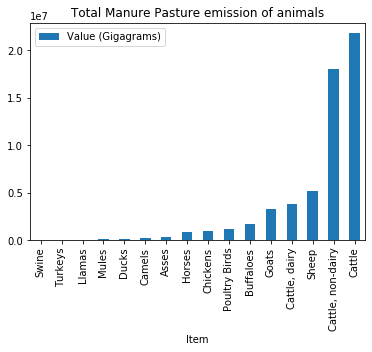

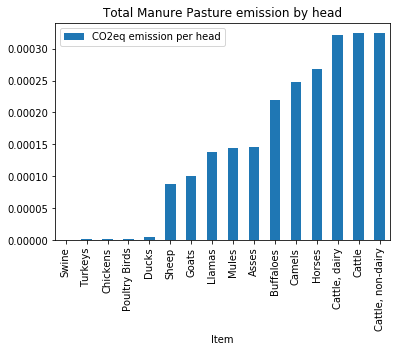

In [59]:
#Grouping stocks count
df_manure_pasture_grouped_stock = df_filter_stock.groupby(["Item"])\
                                ['Value (Head)'].sum().reset_index()
#Grouping total emissions count
df_manure_pasture_grouped_emission = df_filter_emission.groupby(["Item"])\
                                ['Value (Gigagrams)'].sum().reset_index()

df_manure_pasture_grouped_emission.sort_values("Value (Gigagrams)").plot\
.bar(x="Item",
     y="Value (Gigagrams)",
     title="Total Manure Pasture\
 emission of animals")

#Merging to get emission by head
merged = pd.merge(df_manure_pasture_grouped_emission,\
                  df_manure_pasture_grouped_stock,\
                  on = "Item")
merged["CO2eq emission per head"] = merged["Value (Gigagrams)"] / merged["Value (Head)"]
merged.sort_values("CO2eq emission per head").plot\
.bar(x="Item", y="CO2eq emission per head", title="Total Manure Pasture emission by head")

# Manure Management
The table ‘Manure_management’ contains the following data:

GHG emissions from manure management consisting of methane and nitrous oxide gases from aerobic and anaerobic manure decomposition processes

In [60]:
df_manure_management.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,1107,Asses,5111,Stocks,1961,1961,Head,1300000.0,Official data
1,2,Afghanistan,1107,Asses,5111,Stocks,1962,1962,Head,851850.0,Official data
2,2,Afghanistan,1107,Asses,5111,Stocks,1963,1963,Head,1001112.0,Official data
3,2,Afghanistan,1107,Asses,5111,Stocks,1965,1965,Head,1300000.0,Official data
4,2,Afghanistan,1107,Asses,5111,Stocks,1966,1966,Head,1200000.0,Official data


- Checking for null values :

In [63]:
print(df_manure_management.isna().any())
print("Array of years will null values :", df_manure_management[df_manure_management["Value"].isna()]["Year"].unique())

#Removing null values(only in predictions)
df_manure_management = df_manure_management[df_manure_management["Year"]<2030]

Country Code    False
Country         False
Item Code       False
Item            False
Element Code    False
Element         False
Year Code       False
Year            False
Unit            False
Value            True
Flag            False
dtype: bool
Array of years will null values : [2030 2050]


- Element Column:

In [204]:
df_manure_management["Element"].unique()

array(['Stocks', 'Manure (N content) (Manure management)',
       'Implied emission factor for CH4 (Manure management)',
       'Implied emission factor for N2O (Manure management)',
       'Emissions (CH4) (Manure management)',
       'Emissions (CO2eq) from CH4 (Manure management)',
       'Direct emissions (N2O) (Manure management)',
       'Indirect emissions (N2O) (Manure management)',
       'Emissions (N2O) (Manure management)',
       'Direct emissions (CO2eq) (Manure management)',
       'Indirect emissions (CO2eq) (Manure management)',
       'Emissions (CO2eq) from N2O (Manure management)',
       'Emissions (CO2eq) (Manure management)'], dtype=object)

Similarly, in the *Element* column we will only be interested in the value of *Stocks* and the value of *Emissions (CO2eq) (Manure management)* which corresponds to the total aggregate of the GHG emission in CO2eq

In [66]:
#Filter the Element column
split_manure_management = split_on(df_manure_management, "Element")
stocks_manure_management_by_animals = split_manure_management["Stocks"]
emission_manure_management_by_animals = split_manure_management["Emissions (CO2eq) (Manure management)"]

print("Stock unit :", stocks_manure_management_by_animals["Unit"].unique())
print("Emission unit :", emission_manure_management_by_animals["Unit"].unique())

#Removing unit and renaming Value column as we only have one Unit
stocks_manure_management_by_animals.drop("Unit", axis=1, inplace=True)
emission_manure_management_by_animals.drop("Unit", axis=1, inplace=True)
stocks_manure_management_by_animals.rename(columns={"Value": "Value (Head)"}, inplace=True)
emission_manure_management_by_animals.rename(columns={"Value": "Value (Gigagrams)"}, inplace=True)


Stock unit : ['Head']
Emission unit : ['Gigagrams']


- Item column : Removing groups of animals:

In [69]:
print(df_manure_management["Item"].unique())

Animals = ['Asses', 'Buffaloes','Chickens' ,'Camels','Cattle', 'Cattle, dairy', 'Cattle, non-dairy',
           'Ducks','Turkeys','Goats', 'Horses','Llamas', 'Mules','Sheep','Swine','Poultry Birds']

#Filtering animals
dict_elements = {"Country" : ["World"],"Item" : Animals}
columns = ["Country","Item"]
df_filter_stock = select_on(stocks_manure_management_by_animals,columns,dict_elements)
df_filter_emission = select_on(emission_manure_management_by_animals,columns,dict_elements)

['Asses' 'Camels' 'Goats' 'Horses' 'Mules' 'Sheep' 'Buffaloes' 'Ducks'
 'Turkeys' 'Cattle, dairy' 'Cattle, non-dairy' 'Chickens, broilers'
 'Chickens, layers' 'Swine, breeding' 'Swine, market' 'Llamas'
 'All Animals' 'Camels and Llamas' 'Cattle' 'Chickens' 'Mules and Asses'
 'Poultry Birds' 'Sheep and Goats' 'Swine']


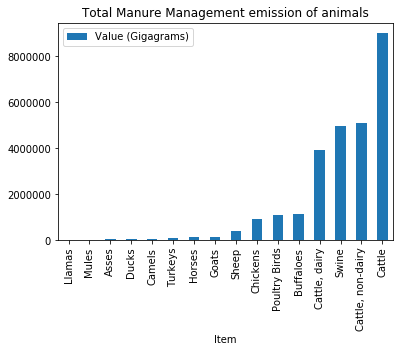

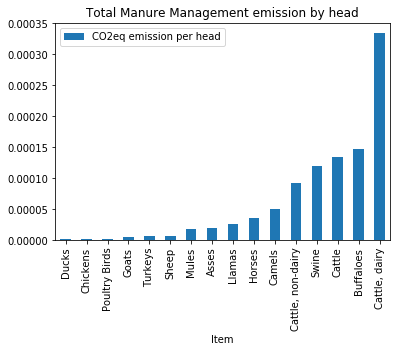

In [70]:
#Grouping stocks count
df_manure_management_grouped_stock = df_filter_stock.groupby(["Item"])\
                                ['Value (Head)'].sum().reset_index()
#Grouping total emission count
df_manure_management_grouped_emission = df_filter_emission.groupby(["Item"])\
                                ['Value (Gigagrams)'].sum().reset_index()

df_manure_management_grouped_emission.sort_values("Value (Gigagrams)").plot\
.bar(x="Item",
     y="Value (Gigagrams)",
     title="Total Manure Management\
 emission of animals")

#Merging to get emission by head
merged = pd.merge(df_manure_management_grouped_emission,\
                  df_manure_management_grouped_stock,\
                  on = "Item")
merged["CO2eq emission per head"] = merged["Value (Gigagrams)"] / merged["Value (Head)"]
merged.sort_values("CO2eq emission per head").plot\
.bar(x="Item", y="CO2eq emission per head", title="Total Manure Management emission by head")

After analyzing the impact of different livestock species we chose to only study the ones that have the most impact which are the following:

**'Cattle, dairy', 'Cattle, non-dairy', 'Swine', 'Cattle', 'Chickens', 'Poultry Birds'**

In [83]:
Animals = ['Cattle, dairy', 'Cattle, non-dairy', 'Swine', 'Cattle', 'Chickens', 'Poultry Birds']

In [85]:
#Filtering all tables to keep only the selected animals
dfs_stock = [stocks_enteric_fermentation_by_animals, stocks_manure_management_by_animals,
             stocks_manure_pasture_by_animals, stocks_manure_soils_by_animals]
dfs_emission = [emission_enteric_fermentation_by_animals, emission_manure_management_by_animals,
               emission_manure_pasture_by_animals, emission_manure_soils_by_animals]

columns = ["Item"]
dict_elements = {"Item": Animals}
for i in range(4):
    dfs_stock[i] = select_on(dfs_stock[i],columns,dict_elements)
    dfs_emission[i] = select_on(dfs_emission[i],columns,dict_elements)

We remove the rows that have a zero value in the *Value* column because these are most likely missing data that we don't want it to make our aggregated data inaccurate 

In [88]:
for i in range(4):
    dfs_stock[i] = dfs_stock[i][dfs_stock[i]["Value (Head)"] != 0]
    dfs_emission[i] = dfs_emission[i][dfs_emission[i]["Value (Gigagrams)"] != 0]

To focus on a good range of years for our analysis we compute for each year the number of countries where there is available data of livestocks.

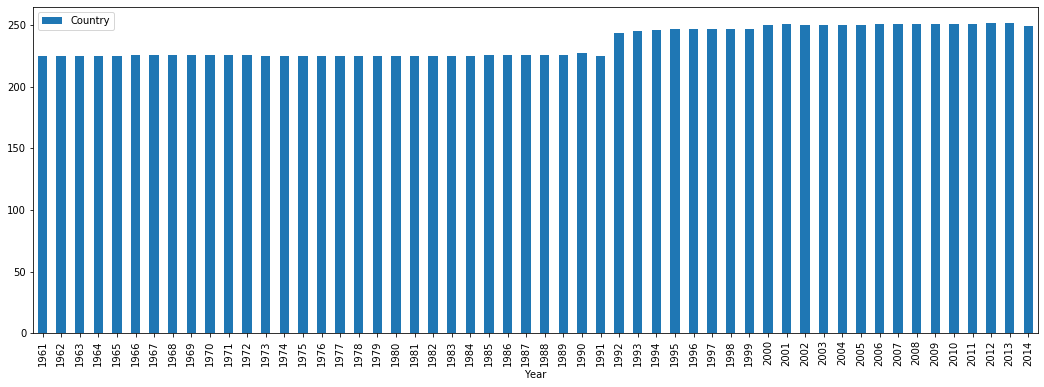

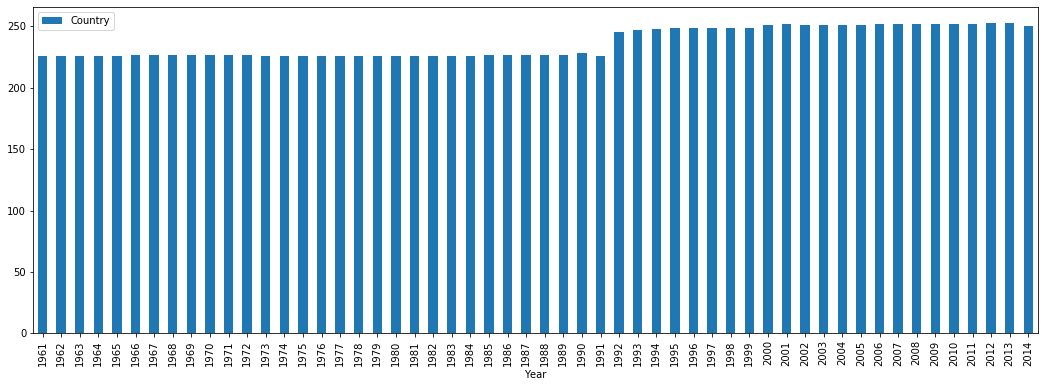

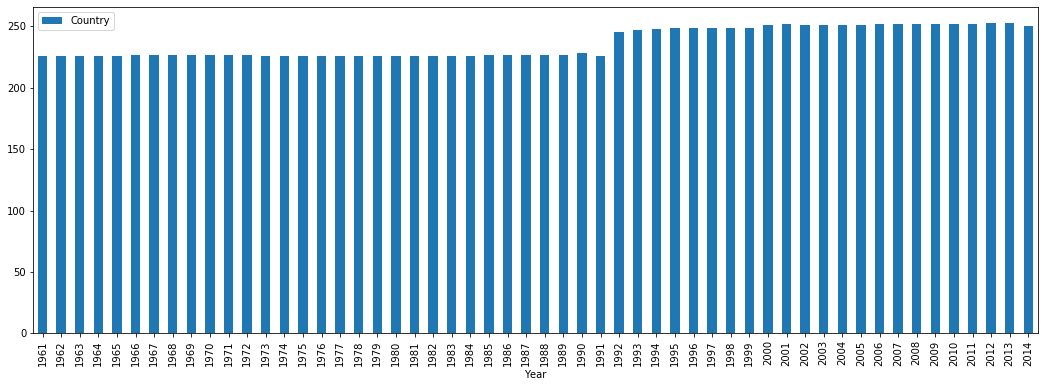

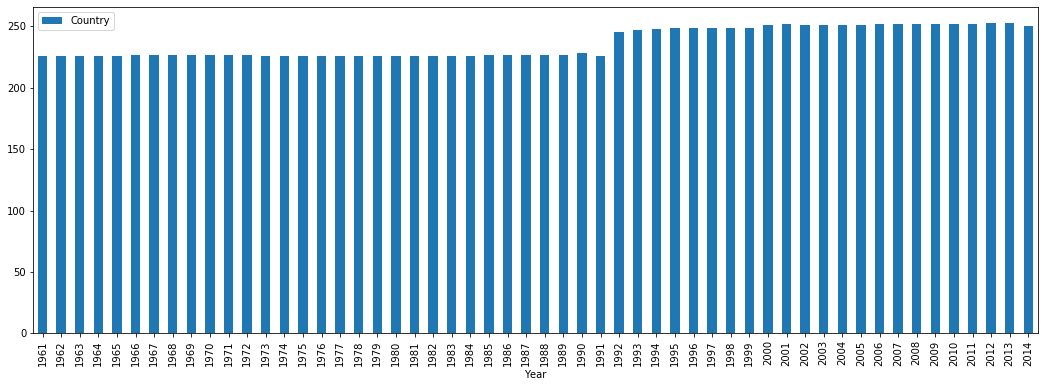

In [331]:
for i in range(4):
    dfs_stock[i].groupby(["Year"])["Country"].nunique().reset_index()\
    .plot.bar(x="Year",y="Country",figsize=(18,6))